# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 4: Web Scraping Job Postings

## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

---

## Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to answer the two questions described above.


---

## Requirements

1. Scrape and prepare your own data.

2. **Create and compare at least two models for each section**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).
   - Section 1: Job Salary Trends
   - Section 2: Job Category Factors

3. Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists. 
   - Make sure to clearly describe and label each section.
   - Comment on your code so that others could, in theory, replicate your work.

4. A brief writeup in an executive summary, written for a non-technical audience.
   - Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

#### BONUS

5. Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.

6. Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

---

## Suggestions for Getting Started

1. Collect data from [Indeed.com](www.indeed.com) (or another aggregator) on data-related jobs to use in predicting salary trends for your analysis.
  - Select and parse data from *at least 1000 postings* for jobs, potentially from multiple location searches.
2. Find out what factors most directly impact salaries (e.g. title, location, department, etc).
  - Test, validate, and describe your models. What factors predict salary category? How do your models perform?
3. Discover which features have the greatest importance when determining a low vs. high paying job.
  - Your Boss is interested in what overall features hold the greatest significance.
  - HR is interested in which SKILLS and KEY WORDS hold the greatest significance.   
4. Author an executive summary that details the highlights of your analysis for a non-technical audience.
5. If tackling the bonus question, try framing the salary problem as a classification problem detecting low vs. high salary positions.

In [2]:
import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from time import sleep

In [3]:
import numpy as np
import pandas as pd

In [4]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException, WebDriverException

## indeed.com

In [4]:
chromedriver = "/Users/Han/Downloads/Data/Git/GA/chromedriver/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(executable_path=chromedriver)

In [439]:
#url = 'https://www.indeed.com/jobs?q=Data+Scientist&l=United+States&sort=date'
url_130k = 'https://www.indeed.com/q-Data-Scientist-$130,000-l-United-States-jobs.html'
driver.get(url_130k)
sleep(3)
html = driver.page_source
soup = BeautifulSoup(html, 'lxml')

In [406]:
scrape = pd.DataFrame(columns=['title','company','location','desc','date','salary','estimate','desired'])

In [381]:
def getlinks_indeed():
    for row in soup.findAll("a", {"class" : "turnstileLink"}):
        if "/cmp/" not in row['href']:
            links.append(row['href'])

In [440]:
def getinfo_indeed():
    #convert to css format
    css_selector = "a[href*="+'"'+href+'"'
    driver.find_element_by_css_selector(css_selector).click()
    sleep(1.5)

    soup1 = BeautifulSoup(driver.page_source, 'lxml')
    title = soup1.find("div", {"id" : "vjs-jobinfo"}).find("div", {"id" : "vjs-jobtitle"}).text
    company = soup1.find("span", {"id" : "vjs-cn"}).text
    location = soup1.find("div", {"id" : "vjs-jobinfo"}).find("span", {"id":"vjs-loc"}).text
#     try:
#         rating = soup1.find("div", {"id" : "vjs-jobinfo"}).find("span", {"class":"rating"})['style']
#         reviews = soup1.find("div", {"id" : "vjs-jobinfo"}).find("span", {"class":"slNoUnderline"}).text
#     except TypeError:
#         rating = 0
#         reviews = 0
    desc = soup1.find("div", {"id" : "vjs-desc"}).text
    date = soup1.find("span", {"class" : "date"}).text
    s_test = (soup1.find("div", {"id" : "vjs-jobinfo"}).find_all('span'))
    if True in ['$' in x.text for x in s_test]:
        salary = s_test[['$' in x.text for x in s_test].index(True)].text
    else:
        salary = -1
    
    estimate = '$13000+' #additional column for jobs using salary estimates
    desired = []
    for skills in soup1.find('div', {'id':'vjs-container'}).findAll('span', {'class':'experienceListItem'}):
        desired.append(skills.text)

    scrape.loc[len(scrape)] = [title, company, location, desc, date, salary, estimate, desired]

In [327]:
#try again function
def try_again():
    last_page = scrape[scrape['title'] == 'Next page'].index.max()
    scrape.drop(index=scrape.index[last_page+1:],inplace=True)

In [452]:
for pages in range(50):
    sleep(50)
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    
    links = []
    getlinks_indeed()
    for href in links:
        try:
            getinfo_indeed()
        
        except WebDriverException:
            # handles popups
            driver.find_element_by_class_name('popover-x').click()
            getinfo_indeed()
            
        except:
            # handles incomplete loading
            sleep(5)
            soup = BeautifulSoup(html, 'lxml')
            try_again()
            links = []
            getlinks_indeed()
            for href in links:
                getinfo_indeed()
    
    #go to next page
    driver.find_elements_by_class_name('pn')[-1].click()
    scrape.loc[len(scrape)] = ['Next page']*8

In [ ]:
# try_again()

In [445]:
scrape.shape

(1162, 8)

In [446]:
len(scrape[scrape[['desc','company']].duplicated()].sort_values(by='desc'))

504

In [450]:
1162-504

658

In [448]:
scrape_unique = scrape.drop(scrape[scrape[['desc','company']].duplicated()].index)
scrape_indeed = scrape_unique[~(scrape_unique['title'] == 'Next page')]

scrape_indeed[scrape_indeed['salary'] != -1].reset_index(drop=True).shape

(8, 8)

In [451]:
#60K: stopped at page 52 (505 rows)
#95K: stopped at page 52 (473 rows)
#130K: stopped at page ? (658 rows)
# scrape_indeed.to_csv('/Users/Han/Downloads/scrape_indeed_60.csv')
# scrape_indeed.to_csv('/Users/Han/Downloads/scrape_indeed_95.csv')
scrape_indeed.to_csv('/Users/Han/Downloads/scrape_indeed_130.csv')

## efinancialcareers.com

In [160]:
#driver.close()

In [4]:
chromedriver = "/Users/Han/Downloads/Data/Git/GA/chromedriver/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(executable_path=chromedriver)

In [12]:
url = 'https://www.efinancialcareers.com/search/?q=data%20scientist&countryCode=US&currencyCode=USD&language=en&facets=*&page=1&pageSize=10&filters.salaryBand=FIRST_TIER%7CSECOND_TIER%7CTHIRD_TIER%7CFOURTH_TIER%7CFIFTH_TIER%7CSIXTH_TIER&ds=sr'
driver.get(url)
sleep(3)
html = driver.page_source
soup = BeautifulSoup(html, 'lxml')

In [20]:
scrape = pd.DataFrame(columns=['title','company','location','desc','date','salary'])

In [25]:
def getinfo_efc():
    soup1 = BeautifulSoup(driver.page_source, 'lxml')

    title = soup1.find('h1').text
    company = soup1.find('li', {'class':'company'}).find('span').text
    location = soup1.find('li', {'class':'location'}).find('span').text
    location = location.splitlines()[-1].lstrip()
    desc = soup1.find('section', {'class':'description'}).text + \
            soup1.find('li', {'class':'position'}).find('span').text
    date = soup1.find('li', {'class':'updated'}).find('span').text
    salary = soup1.find('li', {'class':'salary'}).find('span').text

    scrape.loc[len(scrape)] = [title, company, location, desc, date, salary]

In [230]:
# various types of formatting for special jobs/companies
def getinfo_efc_alt():
    soup1 = BeautifulSoup(driver.page_source, 'lxml')

    title = soup1.find(['h1','h2']).text
    company = soup1.findAll('h2')[1].text
    company = company.splitlines()[-1].lstrip()
    try:
        location = soup1.find('div', {'class':'detailsvisible'}).findAll('li')[0].text
        location = location.split(':')[-1].lstrip()
    except:
        location = 0
    
    desc = soup1.find(['div','section'], {'class':['description','job-description']}).text 
       
    try:
        salary = soup1.find('div', {'class':'detailsvisible'}).findAll('li')[1].text
        salary = salary.split(':')[-1].lstrip()
    except:
        salary = 0
    
    date = 0
    
    scrape.loc[len(scrape)] = [title, company, location, desc, date, salary]

In [112]:
# resume scraping from last left off page
#url = 'https://www.efinancialcareers.com/search/?q=data%20scientist&countryCode=US&currencyCode=USD&language=en&facets=*&page=6&pageSize=10&filters.salaryBand=FIRST_TIER%7CSECOND_TIER%7CTHIRD_TIER%7CFOURTH_TIER%7CFIFTH_TIER%7CSIXTH_TIER&ds=sr'
#driver.get(url)

In [391]:
for pages in range(50):
    sleep(5)
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    
    for link in driver.find_elements_by_class_name('card-title-link'):
        try:
            link.click()
        
        #to handle (ignore) pop-ups
        except WebDriverException:
            driver.switch_to.active_element.click()

        driver.switch_to.window(driver.window_handles[1])
        sleep(5)
        
        try: #scrape
            getinfo_efc()
            driver.close()
            
        except AttributeError: 
            soup1 = BeautifulSoup(driver.page_source, 'lxml')
            if soup1.find('h2').text != None:
                getinfo_efc_alt() # to handle alternative formatting for special jobs/companies
                driver.close()
                
            else:
                sleep(5)
                getinfo_efc()
                driver.close()
            
        #switch back to main page
        driver.switch_to.window(driver.window_handles[0])
        sleep(0.5)

    #go to next page
    driver.find_element_by_id('searchPaginationNext-li').click()
    scrape.loc[len(scrape)] = ['Next page']*7

In [75]:

# soup1 = BeautifulSoup(driver.page_source, 'lxml')

# title = soup1.find('h2').text
# company = soup1.findAll('h2')[1].text
# company = company.splitlines()[-1].lstrip()
# location = soup1.find('div', {'class':'detailsvisible'}).findAll('li')[0].text
# location = location.split(':')[-1].lstrip()


# rating = 0
# reviews = 0
# desc = soup1.find('section', {'class':'description'}).text + \
#         soup1.find('div', {'class':'detailsvisible'}).findAll('li')[2].text
# date = 0
# salary = soup1.find('div', {'class':'detailsvisible'}).findAll('li')[1].text
# salary = salary.split(':')[-1].lstrip()

# test = pd.DataFrame(columns=['title','company','location','rating','reviews','desc','date','salary'])
# test.loc[len(test)] = [title, company, location, rating, reviews, desc, date, salary]
# test

In [231]:
# driver.close()

# #switch back to main page
# driver.switch_to.window(driver.window_handles[0])
# sleep(0.5)

# try_again()
# scrape.shape

In [250]:
scrape_unique = scrape.drop(scrape[scrape[['desc','company']].duplicated()].index)
scrape_efc = scrape_unique[~(scrape_unique['title'] == 'Next page')]

In [277]:
scrape_efc['salary'].tail(10)

150     £excellent + bonus + good package
151                                 $High
152    up to $240,000 plus bonus and bens
153         GBP63000 - GBP73000 per annum
154      £50,000 - £90,000 base + package
155                               £55,000
156         GBP55707 - GBP75707 per annum
157              Up to GBP60000 per annum
158                           Competitive
159                                     0
Name: salary, dtype: object

In [265]:
(x,y) = (scrape_efc.shape)
x-sum(scrape['salary'].value_counts().head().values)

49

In [284]:
scrape_efc.to_csv('/Users/Han/Downloads/scrape_efc.csv')

## simplyhired.com

In [160]:
#driver.close()

In [292]:
chromedriver = "/Users/Han/Downloads/Data/Git/GA/chromedriver/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(executable_path=chromedriver)

In [293]:
url = 'https://www.simplyhired.com/search?q=data+scientist&l=united+states&mip=%2460%2C000&pp=&'
driver.get(url)
sleep(3)
html = driver.page_source
soup = BeautifulSoup(html, 'lxml')

In [294]:
scrape = pd.DataFrame(columns=['title','company','location','desc','date','salary','estimate'])

In [295]:
def getlinks_simplyhired():
    for row in soup.findAll("a", {"class" : "card-link"}):
         links.append("https://www.simplyhired.com"+row['href'])

In [296]:
def getinfo_simplyhired(i):
    soup1 = BeautifulSoup(driver1.page_source, 'lxml')

    title = soup1.find('h1', {'itemprop' : 'title'}).text
    company = soup1.find('span', {'class':'company'}).text
    location = soup1.find('span', {'class':'location'}).text
    desc = soup1.find('div', {'class':'viewjob-description'}).text
    date = soup.findAll('span', {'class':'jobposting-timestamp'})[i].find('time')['datetime']
    salary = soup.findAll('span', {'class':'jobposting-salary'})[i]['data-salary']
    estimate = soup.findAll('span', {'class':'jobposting-salary'})[i]['data-est']

    scrape.loc[len(scrape)] = [title, company, location, desc, date, salary, estimate]

In [297]:
#try again function
def try_again():
        last_page = scrape[scrape['title'] == 'Next page'].index.max()
        scrape.drop(index=scrape.index[last_page+1:],inplace=True)

In [390]:
for pages in range(100):
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    
    links = []
    getlinks_simplyhired()
    for i, job in enumerate(links):
        driver1 = webdriver.Chrome(executable_path=chromedriver)
        driver1.get(job)
        sleep(3)
    
        getinfo_simplyhired(i)
        driver1.close()
  
    #go to next page
    driver.find_element_by_class_name('next-pagination').click()
    scrape.loc[len(scrape)] = ['Next page']*7
    sleep(3)

In [311]:
scrape.shape

(1042, 7)

In [312]:
len(scrape[scrape[['desc','company']].duplicated()].sort_values(by='desc'))

77

In [320]:
scrape_unique = scrape.drop(scrape[scrape[['desc','company']].duplicated()].index)
scrape_simplyhired = scrape_unique[~(scrape_unique['title'] == 'Next page')]

scrape_simplyhired.shape

(964, 7)

In [321]:
scrape_simplyhired[scrape_simplyhired['estimate'] == 'false'].shape

(18, 7)

In [322]:
#stopped at page 50 (964 rows)
scrape_simplyhired.to_csv('/Users/Han/Downloads/scrape_simplyhired.csv')

In [255]:
# try_again()

In [235]:
# for i, job in enumerate(links[:2]):
#     chromedriver = "/Users/Han/Downloads/Data/Git/GA/chromedriver/chromedriver"
#     os.environ["webdriver.chrome.driver"] = chromedriver
#     driver1 = webdriver.Chrome(executable_path=chromedriver)
#     driver1.get(job)
#     sleep(3)
    
#     soup1 = BeautifulSoup(driver1.page_source, 'lxml')
#     print(soup1.find('h1', {'itemprop' : 'title'}).text)
#     print(soup1.find('span', {'class':'company'}).text)
#     print(soup1.find('span', {'class':'location'}).text)
#     print(soup1.find('div', {'class':'viewjob-description'}).text)
    
#     print(soup.findAll('span', {'class':'jobposting-salary'})[i]['data-salary'])
#     print(soup.findAll('span', {'class':'jobposting-salary'})[i]['data-est'])
#     print(soup.findAll('span', {'class':'jobposting-timestamp'})[i].find('time')['datetime'])
#     driver1.close()
#     print('---')

# Cleaning data and merging datasets
#### note: in the end i didnt use indeed.com's data

In [34]:
import string

In [5]:
# file available at 'https://www.dropbox.com/s/mh3u7zcdsabajca/scrape_simplyhired.csv?dl=0'
simplyhired_raw = pd.read_csv('./scraped/scrape_simplyhired.csv', index_col=0)

In [6]:
simplyhired_raw.shape

(964, 7)

In [7]:
simplyhired_raw['clean_salary'] = simplyhired_raw['salary'].str.split()

In [8]:
simplyhired_raw['min_salary'] = simplyhired_raw['clean_salary'].apply(lambda x: float(x[0].strip('$').replace(',','')))

In [9]:
simplyhired_raw['min_salary'] = simplyhired_raw['clean_salary'].apply(lambda x: float(x[0].strip('$').replace(',','')))
simplyhired_raw['max_salary'] = simplyhired_raw['clean_salary'].apply(lambda x: float(x[0].strip('$').replace(',','')) if len(x) == 3 else float(x[2].strip('$').replace(',','')))
simplyhired_raw['salary_unit'] = simplyhired_raw['clean_salary'].apply(lambda x: x[-1])
simplyhired_raw['avg_salary'] = (simplyhired_raw['min_salary'] + simplyhired_raw['max_salary'])/2

In [10]:
simplyhired_raw['salary_unit'].unique()

array(['year', 'hour', 'month'], dtype=object)

In [11]:
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['salary_unit'] == 'hour'].index, 'avg_salary'] =  simplyhired_raw[simplyhired_raw['salary_unit'] == 'hour']['avg_salary']*7*260
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['salary_unit'] == 'month'].index, 'avg_salary'] = simplyhired_raw[simplyhired_raw['salary_unit'] == 'month']['avg_salary']*12

In [12]:
# locations are clean
# simplyhired_raw['location'].unique()

In [13]:
simplyhired_raw[simplyhired_raw['company'].isnull()]

,title,company,location,desc,date,salary,estimate,clean_salary,min_salary,max_salary,salary_unit,avg_salary
1032,Data Scientist,NaN,"San Francisco, CA",Vevo is the world’s leading all-premium music ...,2018-09-11T01:57:36Z,"$110,000 - $150,000 a year",True,"[$110,000, -, $150,000, a, year]",110000.0,150000.0,year,130000.0


In [14]:
simplyhired_raw.loc[1032,'company'] = 'Vevo'

In [15]:
simplyhired_raw['month_posted'] = pd.to_datetime(simplyhired_raw['date']).dt.month

In [48]:
simplyhired_raw['desc_clean'] = simplyhired_raw['desc'].apply(lambda x: x.replace('\n', '. '))

In [17]:
simplyhired_raw['location'].apply(lambda x: x.split(',')[-1]).unique()

array(['Remote', ' CA', ' DC', ' FL', ' TN', ' NY', ' NJ', ' HI', ' WA',
       'United States', ' MA', ' TX', ' GA', ' IL', 'California', ' NC',
       ' VA', ' MD', ' MI', 'New York State', ' OR', 'Work at Home',
       ' UT', 'Home Based', ' AZ', ' NV', ' OH', ' CT', ' MO', 'Indiana',
       ' WI', ' IA', 'Georgia', ' CO', ' RI', 'Virginia', ' AL',
       'New Jersey', ' ME', ' KY', ' PA', ' IN', 'Idaho', ' NH', ' DE',
       ' NE', ' ID', ' NM', ' SC', ' MN', ' AR', 'Illinois', ' WV', ' AK'],
      dtype=object)

In [18]:
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['location'] == 'California'].index, 'location'] = ' CA'
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['location'] == 'New York State'].index, 'location'] = ' NY'
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['location'] == 'Indiana'].index, 'location'] = ' IN'
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['location'] == 'Georgia'].index, 'location'] = ' GA'
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['location'] == 'Virginia'].index, 'location'] = ' VA'
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['location'] == 'New Jersey'].index, 'location'] = ' NJ'
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['location'] == 'Idaho'].index, 'location'] = ' ID'
simplyhired_raw.loc[simplyhired_raw[simplyhired_raw['location'] == 'Illinois'].index, 'location'] = ' IL'

In [19]:
others = simplyhired_raw[(simplyhired_raw['location'] == 'Remote') |(simplyhired_raw['location'] == 'United States') |
                (simplyhired_raw['location'] == 'Work at Home') | (simplyhired_raw['location'] == 'Home Based')].index
simplyhired_raw.loc[others, 'location'] = 'Remote'

In [20]:
simplyhired_raw['location'].apply(lambda x: x.split(',')[-1]).unique()

array(['Remote', ' CA', ' DC', ' FL', ' TN', ' NY', ' NJ', ' HI', ' WA',
       ' MA', ' TX', ' GA', ' IL', ' NC', ' VA', ' MD', ' MI', ' OR',
       ' UT', ' AZ', ' NV', ' OH', ' CT', ' MO', ' IN', ' WI', ' IA',
       ' CO', ' RI', ' AL', ' ME', ' KY', ' PA', ' ID', ' NH', ' DE',
       ' NE', ' NM', ' SC', ' MN', ' AR', ' WV', ' AK'], dtype=object)

In [21]:
simplyhired = simplyhired_raw.drop(['desc','date','salary','estimate','clean_salary','min_salary','max_salary','salary_unit'], axis=1)

In [22]:
simplyhired.head()

,title,company,location,avg_salary,month_posted,desc_clean
0,Data Scientist,Crossover,Remote,100000.0,8,$ 100k USD/year. $ 50 USD/hour. . 40h/week. . ...
1,Researcher,Riot Games,"Los Angeles, CA",70000.0,7,Riot Games was established in 2006 by entrepre...
2,Data Scientist,U.S. Federal Government,"Washington, DC",99000.0,7,Duties. Summary. The Directorate of Digital In...
3,Data Scientist - Full Time,Miami HEAT,"Miami, FL",96000.0,10,Description of the Position:. This position is...
4,"Data Scientist, Routing/Dispatching",Tesla,"Fremont, CA",145000.0,10,"Role. . In this role, you will join a small te..."


## clean EFC data

In [23]:
# file available at 'https://www.dropbox.com/s/f7grxoergtyhah4/scrape_efc.csv?dl=0'
efc_raw = pd.read_csv('./scraped/scrape_efc.csv', index_col=0)

In [24]:
#filter out non-US jobs
efc_raw.drop(efc_raw.loc[121:].index, inplace= True)

In [25]:
def salary_check(salary):
    value = 0
    for char in salary:
        value += char.isnumeric()
    return value

In [26]:
efc_raw['salary_check'] = efc_raw['salary'].apply(salary_check)
efc = efc_raw[(efc_raw['salary_check'] != 0) & (efc_raw['salary'] != '0')]

In [27]:
efc.drop(['rating','reviews','salary_check'],axis=1,inplace=True)
efc.reset_index(inplace=True, drop=True)

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [28]:
# data is too dirty and I dont want to waste too much time - so manually change
print(efc.loc[6, 'salary'])
print(efc.loc[23, 'salary'])

Financial Services Consultant - Data Analyst $55k + and bonus eligible
200,000 to 300,000


In [29]:
efc.loc[6, 'salary'] = '$55k + and bonus eligible'
efc.loc[23, 'salary'] = '200,000 - 300,000'

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/Han/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Han/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
def efc_stripper(row):
    text = []
    for char in row:
        if char.isalpha():
            if char.lower() == 'k':
                text.append('000')
            else:
                pass
        else:
            if char in string.punctuation:
                if (char == '-') or (char == '.'):
                    text.append(char)
            else:
                text.append(char)
    # change to list where min sal is x[0] and max sal is x[1] --> [190000 ,  230000  ]
    sal_range = (''.join(text)).split('-')
    
    #force singular salary values to have min/max
    if len(sal_range) < 2:
        sal_range.append(sal_range[0])
    
    for i, sal in enumerate(sal_range):
        sal_range[i] = float(sal)
    
    return sal_range

In [35]:
efc.loc[:, 'salary_clean'] = efc.loc[:, 'salary'].apply(efc_stripper)
efc.loc[:, 'min_salary'] = efc.loc[:, 'salary_clean'].apply(lambda x: x[0])
efc.loc[:, 'max_salary'] = efc.loc[:, 'salary_clean'].apply(lambda x: x[1])

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:
# again, manually check and clean dirty data
efc[(efc['min_salary'] < 5000) | (efc['max_salary'] < 5000)]

,title,company,location,desc,date,salary,salary_clean,min_salary,max_salary
14,Core Java Developer,Synechron Inc.,"New York, NY, USA",\n\nSynechron is looking strong Java Lead Deve...,\n 15 Oct 18,$100 - $140,"[100.0, 140.0]",100.0,140.0
19,ABL Credit Officer,The Delafield Group,"Livingston, NJ, USA",\n\nCandidate will be responsible for the qual...,\n 05 Oct 18,$225,"[225.0, 225.0]",225.0,225.0
21,Systematic Quant Trading seat with award winni...,Jove International,"Boston, MA, USA",\n\nMy client is a leading quantitative tradin...,\n 15 Oct 18,200-350k USD,"[200.0, 350000.0]",200.0,350000.0
25,Excel/Vba consultants,Focus Capital Markets,"New York, NY, USA",\n\nMigrate an Excel based portfolio analytic ...,\n 24 Sep 18,80 dollars per hour,"[80.0, 80.0]",80.0,80.0
26,Senior Java Developer,Adaptive Financial Consulting,"New York, NY, USA","\n\nWe are Adaptive, a successful and growing ...",\n 18 Oct 18,$150-$250K DOE,"[150.0, 250000.0]",150.0,250000.0


In [37]:
efc.loc[[14,19], ['min_salary','max_salary']] = efc.loc[[14,19], ['min_salary','max_salary']]*100
efc.loc[[21,26], ['min_salary']] = efc.loc[[21,26], ['min_salary']]*100
efc.loc[25, ['min_salary','max_salary']] = efc.loc[25, ['min_salary','max_salary']]*7*260

In [38]:
efc.drop(['salary','salary_clean'],axis=1,inplace=True)
efc['avg_salary'] = (efc['min_salary'] + efc['max_salary'])/2

/Users/Han/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
efc.loc[:, 'month_posted'] = efc.loc[:, 'date'].apply(lambda x: (pd.to_datetime(x.replace('\n',''))).month if x != '0' else 0)
efc.loc[:, 'location'] = efc.loc[:, 'location'].apply(lambda x: x.replace(', USA',''))

In [40]:
efc.loc[:, 'desc_clean'] = efc['desc'].str.replace('\n','. ')
efc.drop(['desc','date','min_salary','max_salary'], axis=1, inplace=True)

## Merge

In [41]:
columns_list = ['title','company','location','month_posted','desc_clean','avg_salary']

In [42]:
simplyhired_test = simplyhired.loc[:, columns_list]

In [43]:
efc_test = efc.loc[:, columns_list]

In [44]:
simplyhired_test['site'] = 'SH'
efc_test['site'] = 'efc'

In [45]:
jobs = pd.concat([efc_test, simplyhired_test]).reset_index(drop=True)

In [46]:
jobs.to_csv('/Users/Han/Downloads/jobs_data.csv')

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.



In [64]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import string

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [66]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS as esw
from nltk.corpus import stopwords
import spacy
import en_core_web_sm
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression

In [69]:
# https://www.dropbox.com/s/gwraeplc500l084/jobs_data.csv?dl=0
jobs = pd.read_csv('./scraped/jobs_data.csv', index_col=0)

In [70]:
np.percentile(jobs['avg_salary'], 75) , np.percentile(jobs['avg_salary'], 25)

(140000.0, 111500.0)

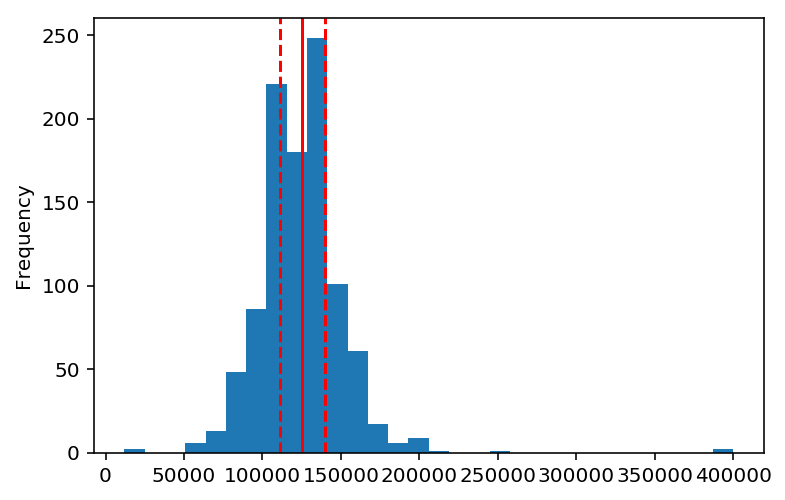

In [71]:
jobs['avg_salary'].plot.hist(bins=30)
plt.axvline(jobs['avg_salary'].mean(), c='r')
plt.axvline(np.percentile(jobs['avg_salary'], 75), c='r', ls='--')
plt.axvline(np.percentile(jobs['avg_salary'], 25), c='r', ls='--')

In [72]:
# 3 classes
salary_band = []
for job in jobs['avg_salary']:
    if job > np.percentile(jobs['avg_salary'], 75):
        salary_band.append('high')
    elif job < np.percentile(jobs['avg_salary'], 25):
        salary_band.append('low')
    else:
        salary_band.append('medium')

In [74]:
jobs['salary_band'] = salary_band

In [75]:
jobs['salary_band'].value_counts()

medium    554
low       250
high      198
Name: salary_band, dtype: int64

In [76]:
554/(555+447)

0.5528942115768463

In [77]:
def lower_case(word_array):
    word_array = word_array.str.lower()
    return word_array

stop = stopwords.words('english')
def remove_stopwords(word_array):
    word_array = word_array.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    return word_array
    
def remove_punc(word_array):
    word_array = word_array.str.replace('[^\w\s]' ,'')
    word_array = word_array.str.replace('\n','')
    word_array = word_array.str.replace('  ' ,' ')
    return word_array

st = PorterStemmer()
def stem_words(word_array):
    word_array = word_array.apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    return word_array

wnl = WordNetLemmatizer()
def lemm_words(word_array):
    word_array = word_array.apply(lambda x: " ".join([wnl.lemmatize(word) for word in x.split()]))
    return word_array

def remove_numbers(word_array):
    word_array = word_array.apply(lambda x : re.sub(r'\d+', '', x))
    return word_array

In [78]:
def clean_pipeline(word_array):
    word_array = lower_case(word_array)
    word_array = remove_stopwords(word_array)
    word_array = remove_punc(word_array)
    word_array = lemm_words(word_array)
    word_array = remove_numbers(word_array)
    #word_array = stem_words(word_array)
    #word_array = tokenize(word_array)
    return word_array

In [79]:
jobs['desc_nlp'] = clean_pipeline(jobs['desc_clean'])
jobs['title_nlp'] = clean_pipeline(jobs['title'])

### Desc as a predictor

In [80]:
X = jobs.loc[:,['company','location','month_posted','desc_nlp','title_nlp','site']]
y = jobs['salary_band']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25)

In [82]:
cv_desc = CountVectorizer(ngram_range=(1,1))
cv_desc.fit(X_train['desc_nlp'])
len(cv_desc.get_feature_names())    

14240

In [83]:
X_train_desc = pd.DataFrame(cv_desc.transform(X_train['desc_nlp']).todense(), \
                            columns=[x+'_desc' for x in cv_desc.get_feature_names()]) 
X_test_desc = pd.DataFrame(cv_desc.transform(X_test['desc_nlp']).todense(), \
                            columns=[x+'_desc' for x in cv_desc.get_feature_names()]) 

In [84]:
X_train_desc.shape

(751, 14240)

In [85]:
nb = MultinomialNB()
nb.fit(X_train_desc, y_train)
nb_pred = nb.predict(X_test_desc)
np.mean(cross_val_score(nb, X_train_desc, y_train, cv=3))

0.6165549818320902

In [86]:
print(classification_report(y_test,nb_pred))

              precision    recall  f1-score   support

        high       0.76      0.23      0.36        56
         low       0.63      0.33      0.44        57
      medium       0.62      0.92      0.74       138

   micro avg       0.63      0.63      0.63       251
   macro avg       0.67      0.50      0.51       251
weighted avg       0.66      0.63      0.59       251



In [87]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_desc, y_train)
rfc_pred = rfc.predict(X_test_desc)
print(np.mean(cross_val_score(rfc, X_train_desc, y_train, cv=3)))

0.5872527570599859


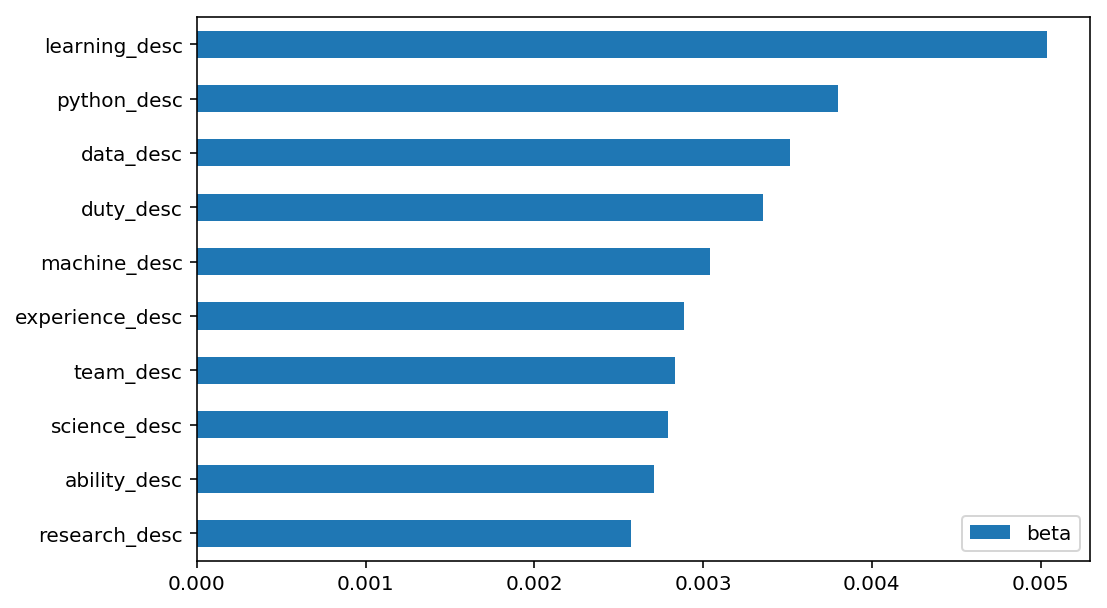

In [88]:
rfc_model = pd.DataFrame(data=rfc.feature_importances_, index=X_train_desc.columns, columns=['beta'])
rfc_model = rfc_model[rfc_model['beta'] != 0].sort_values(by='beta', ascending=False)
rfc_model.head(10).plot.barh(figsize=(8,5))
plt.gca().invert_yaxis()

### Title as a predictor

In [89]:
cv_title = CountVectorizer(ngram_range=(1,1))
cv_title.fit(X_train['title_nlp'])
len(cv_title.get_feature_names())    

446

In [90]:
X_train_title = pd.DataFrame(cv_title.transform(X_train['title_nlp']).todense(), \
                            columns=[x+'_title' for x in cv_title.get_feature_names()]) 
X_test_title = pd.DataFrame(cv_title.transform(X_test['title_nlp']).todense(), \
                            columns=[x+'_title' for x in cv_title.get_feature_names()]) 

In [91]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_title, y_train)
rfc_pred = rfc.predict(X_test_title)
np.mean(cross_val_score(rfc, X_train_title, y_train, cv=3))

0.552601389685727

In [92]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

        high       0.71      0.27      0.39        56
         low       0.35      0.14      0.20        57
      medium       0.59      0.88      0.71       138

   micro avg       0.58      0.58      0.58       251
   macro avg       0.55      0.43      0.43       251
weighted avg       0.56      0.58      0.52       251



In [93]:
cv_title = TfidfVectorizer(ngram_range=(1,1), max_df=150)
cv_title.fit(X_train[y_train != 'medium']['title_nlp'])
len(cv_title.get_feature_names())    

270

In [94]:
X_train_title = pd.DataFrame(cv_title.transform(X_train[y_train != 'medium']['title_nlp']).todense(), \
                            columns=[x+'_title' for x in cv_title.get_feature_names()]) 
X_test_title = pd.DataFrame(cv_title.transform(X_test['title_nlp']).todense(), \
                            columns=[x+'_title' for x in cv_title.get_feature_names()]) 

In [95]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_title, y_train[y_train != 'medium'])
rfc_pred = rfc.predict(X_test_title)
scores = cross_val_score(rfc, X_train_title, y_train[y_train != 'medium'], cv=5)
np.mean(scores), np.std(scores)

(0.6536222630164684, 0.037703665880292975)

In [96]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

        high       0.44      0.45      0.44        56
         low       0.25      0.86      0.39        57
      medium       0.00      0.00      0.00       138

   micro avg       0.29      0.29      0.29       251
   macro avg       0.23      0.44      0.28       251
weighted avg       0.16      0.29      0.19       251



/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### title is not bad at predicting high and low classes
</br>

In [97]:
# nb = MultinomialNB()
# nb.fit(X_train_title, y_train)
# nb_pred = nb.predict(X_test_title)
# print(np.mean(cross_val_score(nb, X_train_title, y_train, cv=3)))
# print(classification_report(y_test,nb_pred))

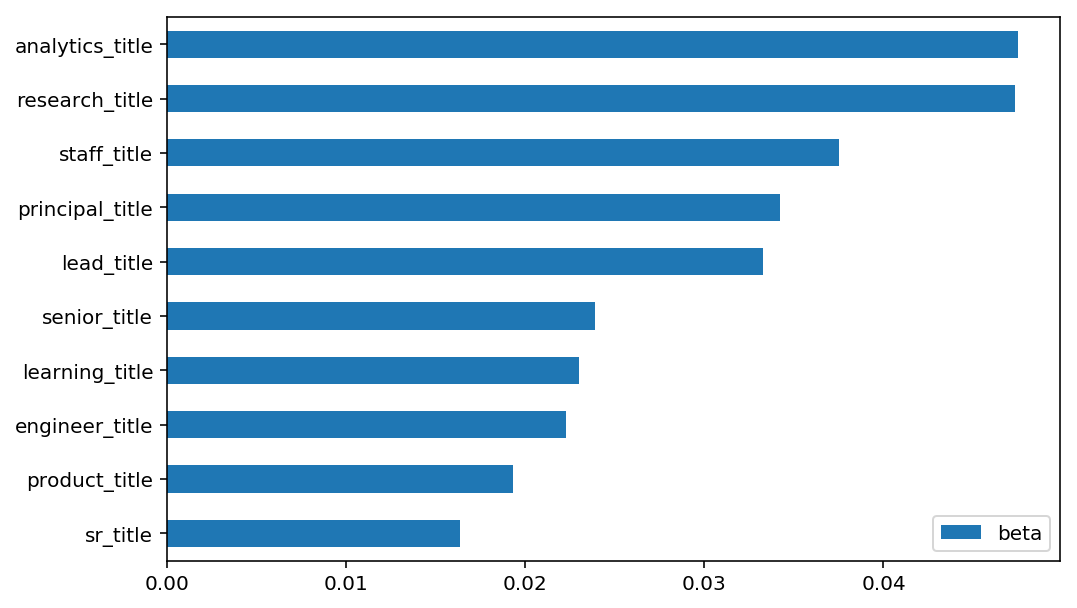

In [98]:
rfc_model = pd.DataFrame(data=rfc.feature_importances_, index=X_train_title.columns, columns=['beta'])
rfc_model = rfc_model[rfc_model['beta'] != 0].sort_values(by='beta', ascending=False)
rfc_model.head(10).plot.barh(figsize=(8,5))
plt.gca().invert_yaxis()

### Location, Site, Month_posted, Company as predictors

In [99]:
X.head()

,company,location,month_posted,desc_nlp,title_nlp,site
0,Michael Page International - US,"Manhattan, NY",10,data scientist overseeing team three also will...,data scientist,efc
1,Glocomms,"New York, NY",9,cybersecurity startup seeking data engineer he...,data engineer,efc
2,Glocomms,"New York, NY",8,software service solution company recognized g...,data engineer,efc
3,Jove International,"New York, NY",10,firm incredibly strong track record within sys...,senior machine learning software engineer lead...,efc
4,Glocomms,"Santa Clara, CA",8,software service solution company recognized g...,big data architect,efc


In [100]:
# EDA on location first
X['state'] = X['location'].apply(lambda x: x.split(',')[-1])

In [101]:
pivot = X.join(y).pivot_table(values='site', index='state', columns='salary_band', aggfunc='count'
                     ).sort_values(by='high', ascending = False)

pivot['sum'] = pivot['high'] + pivot['medium'] + pivot['low']
minority_states = pivot[pivot['sum'].isna()].index.tolist()

In [102]:
pivot.head()

salary_band,high,low,medium,sum
state,,,,
CA,90.0,17.0,139.0,246.0
NY,59.0,29.0,85.0,173.0
VA,9.0,9.0,20.0,38.0
NJ,7.0,6.0,13.0,26.0
Remote,5.0,15.0,25.0,45.0


In [103]:
X['state'] = X['state'].apply(lambda x : 'Others' if x in minority_states else x)

In [104]:
#re-pivot after consolidating minority states
pivot = X.join(y).pivot_table(values='site', index='state', columns='salary_band', aggfunc='count'
                     ).sort_values(by='high', ascending = False)

pivot['sum'] = pivot['high'] + pivot['medium'] + pivot['low']

In [105]:
pivot['high%'] = pivot['high']/pivot['sum']
pivot['medium%'] = pivot['medium']/pivot['sum']
pivot['low%'] = pivot['low']/pivot['sum']

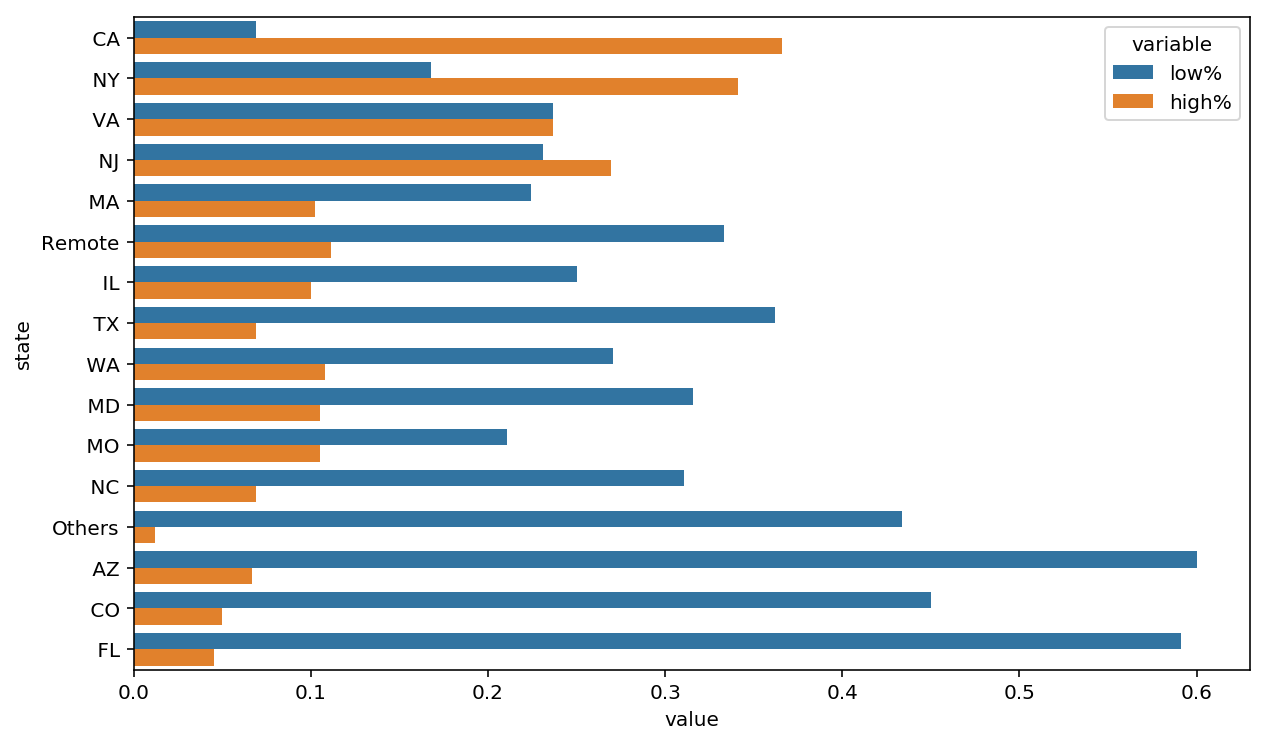

In [106]:
plt.figure(figsize=(10,6))
sns.barplot(data=pd.melt(pd.DataFrame(pivot['low%']).join(pivot['high%']).reset_index(),id_vars='state'), y='state', x='value', hue='variable', orient='h')


In [107]:
pivot2 = pivot.reset_index().drop(['high','low','medium','sum'],axis=1)

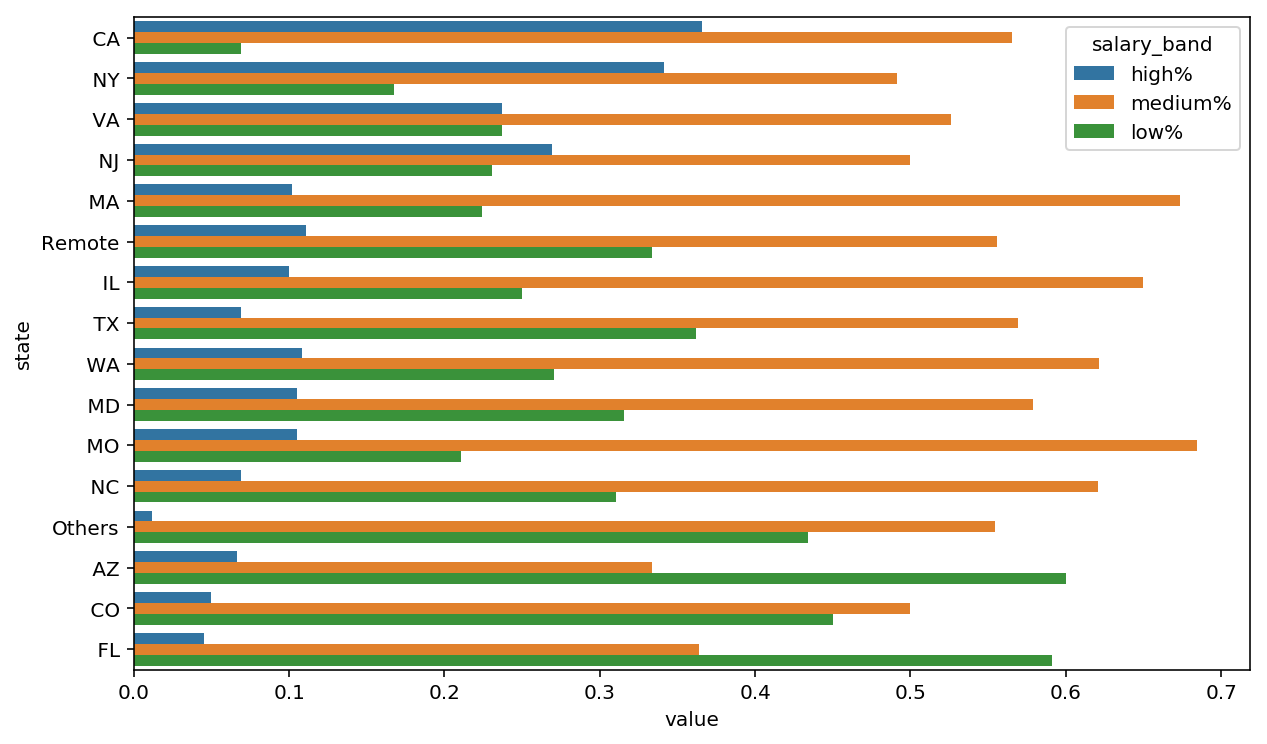

In [108]:
plt.figure(figsize=(10,6))
sns.barplot(data=pd.melt(pivot2,id_vars='state'), y='state', x='value', hue='salary_band', orient='h')

In [109]:
from sklearn.preprocessing import OneHotEncoder
labeler = OneHotEncoder()

In [110]:
X_cat = labeler.fit_transform(X[['state']]).toarray()
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat,y,random_state=42, test_size=0.25)

X_cat_train = X_cat_train[y_cat_train != 'medium']
y_cat_train = y_cat_train[y_cat_train != 'medium']

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_cat_train, y_cat_train)

rfc_pred = rfc.predict(X_cat_test)
np.mean(cross_val_score(rfc, X_cat_train, y_cat_train, cv=3))

0.7493954131122272

In [111]:
loc_proba = rfc.predict_proba(X_cat_test)

In [112]:
pd.DataFrame(loc_proba, columns=['high','low']).join(pd.DataFrame(y_cat_test).reset_index(drop=True)).head(10)

,high,low,salary_band
0,0.039048,0.960952,medium
1,0.618776,0.381224,medium
2,0.039048,0.960952,medium
3,0.188075,0.811925,medium
4,0.618776,0.381224,low
5,0.039048,0.960952,low
6,0.188075,0.811925,low
7,0.814911,0.185089,high
8,0.101835,0.898165,low
9,0.814911,0.185089,high


In [113]:
print(classification_report(y_cat_test,rfc_pred))

              precision    recall  f1-score   support

        high       0.46      0.73      0.56        56
         low       0.32      0.91      0.48        57
      medium       0.00      0.00      0.00       138

   micro avg       0.37      0.37      0.37       251
   macro avg       0.26      0.55      0.35       251
weighted avg       0.17      0.37      0.23       251



/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### location is a strong predictor of high and low classes
</br>

In [114]:
# EDA on site - used a proxy for industry (i.e. efc is finance/banking, simplyhired is more generic)
group = X[['site','location']].join(y).groupby(by=['site','salary_band']).count()
group

location
site salary_band          
SH   high              176
     low               241
     medium            547
efc  high               22
     low                 9
     medium              7

In [115]:
X['site'].value_counts()

SH     964
efc     38
Name: site, dtype: int64

In [116]:
group = group.reset_index()
group['%'] = 1

In [117]:
group.loc[group[group['site'] == 'SH'].index, '%'] = group.loc[group[group['site'] == 'SH'].index, 'location'] / 964
group.loc[group[group['site'] == 'efc'].index, '%'] = group.loc[group[group['site'] == 'efc'].index, 'location'] / 38

In [118]:
group

,site,salary_band,location,%
0,SH,high,176,0.182573
1,SH,low,241,0.250000
2,SH,medium,547,0.567427
3,efc,high,22,0.578947
4,efc,low,9,0.236842
5,efc,medium,7,0.184211


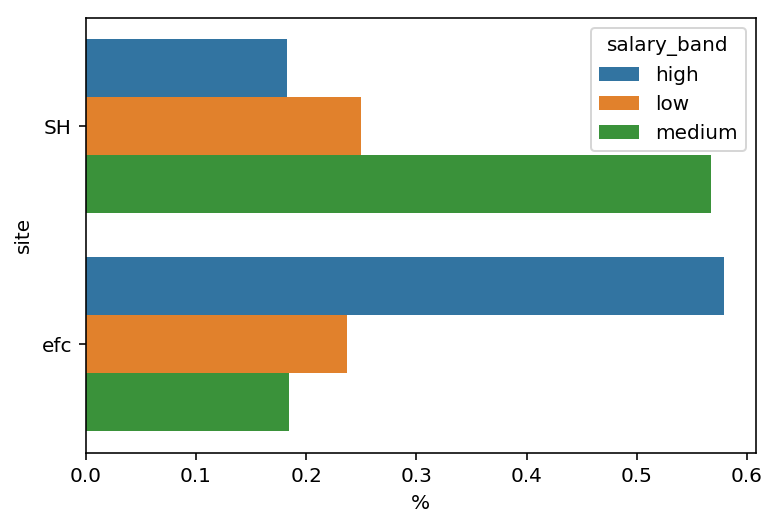

In [119]:
sns.barplot(data = group.drop('location', axis=1), y='site', x='%', hue='salary_band')

In [120]:
X_cat = labeler.fit_transform(X[['site']]).toarray()
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat,y,random_state=42, test_size=0.25)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_cat_train, y_cat_train)

rfc_pred = rfc.predict(X_cat_test)
np.mean(cross_val_score(rfc, X_cat_train, y_cat_train, cv=3))

0.5645804806527698

In [121]:
print(classification_report(y_cat_test,rfc_pred))

              precision    recall  f1-score   support

        high       0.89      0.14      0.25        56
         low       0.00      0.00      0.00        57
      medium       0.57      0.99      0.72       138

   micro avg       0.58      0.58      0.58       251
   macro avg       0.49      0.38      0.32       251
weighted avg       0.51      0.58      0.45       251



/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### site is a strong predictor of high and medium classes
</br>

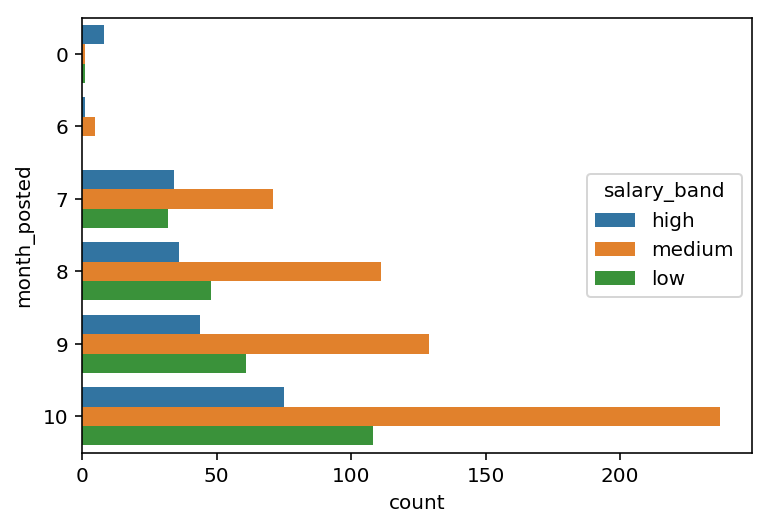

In [122]:
# month_posted
sns.countplot(data = X[['month_posted']].join(y), y='month_posted', hue='salary_band')

In [123]:
# company
X['company'].nunique()

707

In [124]:
X_cat = labeler.fit_transform(X[['company']]).toarray()
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat,y,random_state=42, test_size=0.25)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_cat_train, y_cat_train)

rfc_pred = rfc.predict(X_cat_test)
np.mean(cross_val_score(rfc, X_cat_train, y_cat_train, cv=3))

0.5552945751259003

In [125]:
print(classification_report(y_cat_test,rfc_pred))

              precision    recall  f1-score   support

        high       0.52      0.20      0.29        56
         low       0.50      0.11      0.17        57
      medium       0.57      0.91      0.70       138

   micro avg       0.57      0.57      0.57       251
   macro avg       0.53      0.40      0.39       251
weighted avg       0.55      0.57      0.49       251



In [126]:
tf_title = TfidfVectorizer(ngram_range=(1,1))
tf_title.fit(X['company'])
len(tf_title.get_feature_names())   

960

In [127]:
X_train_coy = pd.DataFrame(tf_title.transform(X['company']).todense(), columns=tf_title.get_feature_names()) 

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_coy, y)
scores = cross_val_score(rfc, X_train_coy, y, cv=5)
np.mean(scores), np.std(scores)

(0.5458760469011725, 0.02809759595217164)

#### Nothing much for month_posted and company

In [128]:
# X_cat = labeler.fit_transform(X[['state','site','company']]).toarray()
# X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat,y,random_state=42, test_size=0.25)

# rfc = RandomForestClassifier(n_estimators=100)
# rfc.fit(X_cat_train, y_cat_train)

# rfc_pred = rfc.predict(X_cat_test)
# np.mean(cross_val_score(rfc, X_train_nlp, y_train, cv=3))

## Try extracting years of experience from job desc

In [129]:
import re

In [130]:
# use regex to identify sentences which contains both 'years' and 'experience', then extract out the digits and pass into a list
test = pd.DataFrame(columns=['list'])

for i, job in enumerate(jobs['desc_clean'].str.lower()):
     test.loc[len(test)] = [re.findall('\+?\d+',''.join(re.findall('[^.*]*experience[^.*]*\.',''.join(re.findall('[^.*]*years[^.*]*\.', job)))))]

In [131]:
test.loc[18]

list    [3, 27001, 2]
Name: 18, dtype: object

In [132]:
re.findall('[^.*]*experience[^.*]*\.',''.join(re.findall('[^.*]*years[^.*]*\.', jobs['desc_clean'][18])))

[') 3+ years experience working in an Info Sec department Knowledge of ISO 27001/2, NIST, etc.']

In [133]:
# create function to filter out unrealistically large numbers (like above)
def drop_20(x):
    if len(x) != 0:
        for num in x:
            if float(num) > 20:
                x.pop(x.index(num))
    else:
        x
    return x

In [134]:
test_drop20 = test['list'].apply(drop_20)

In [135]:
# get max years of experience
year_exp = test_drop20.apply(lambda x: -1 if len(x) == 0 else max([float(char) for char in x]))
# get number of requirements listed
num_requirements = test_drop20.apply(len)

In [136]:
year_exp.unique()

array([  5.,  -1.,  10.,   1.,   4.,   3.,   6.,   8.,   7.,   2.,  15.,
       203.,  12.,   9.,  87.,  11.,  20.,  18.])

In [137]:
# check large numbers, see if legit or not
year_exp[year_exp == 20]

911    20.0
Name: list, dtype: float64

In [138]:
re.findall('[^.*]*experience[^.*]*\.',''.join(re.findall('[^.*]*years[^.*]*\.', jobs['desc_clean'][911])))

[") and 20 years related scientific/engineering experience, a Master's degree and 15 years of job related experience, or a Ph.",
 'D and 12 years of job related experience.',
 ' A PE License may substitute for 2 years of experience.']

In [139]:
num_requirements.unique()

array([ 2,  0,  1,  4,  6,  3,  5,  8, 14, 21, 12,  7, 11])

In [140]:
num_requirements[num_requirements == 21]

688    21
Name: list, dtype: int64

In [141]:
re.findall('[^.*]*experience[^.*]*\.',''.join(re.findall('[^.*]*years[^.*]*\.', jobs['desc_clean'][688])))

["\\nMinimum Qualifications: \\n\\nMaster's Degree in Mathematics, Physics, or Computer and Information Science\\n(substitution: Bachelors with significant relevant work experience instead of a post-graduate degree)\\n\\n5 - 10 years in Data Analytics\\n5 - 7 years using Large Datasets\\n5 - 7 years utilizing Statistical Software\\n5 - 7 years in Data Visualization\\n3 - 5 years in Predictive Modeling\\n1 - 3 years in the Healthcare Industry\\n1 - 3 years in Research and Development\\n1 - 3 years in a Business Analyst role\\n1 - 3 years in Consulting\\nPreferred Qualifications: \\n\\nNatural Language Processing (NLP)\\nRobotic Process Automation (RPA)\\n1 + years of scientific research\\n1 + years in the Healthcare Industry\\nSignificant written & oral presentation experience\\nStatistical Analysis\\nReferral Award Payout Level: 2\\n\\nHighmark Health and its affiliates prohibit discrimination against qualified individuals based on their status as protected veterans or individuals with

In [142]:
exp_test = pd.DataFrame([num_requirements,year_exp],index=['num_req','max_years']).transpose()
jobs_test = jobs.join(exp_test)

In [143]:
# drop rows with null values to try first
jobs_test_drop = jobs_test[jobs_test['max_years'] != -1]
jobs_test_drop.head()

,title,company,location,month_posted,desc_clean,avg_salary,site,salary_band,desc_nlp,title_nlp,num_req,max_years
0,Data Scientist,Michael Page International - US,"Manhattan, NY",10,. . Data Scientist who will be overseeing a te...,175000.0,efc,high,data scientist overseeing team three also will...,data scientist,2.0,5.0
4,Big Data Architect,Glocomms,"Santa Clara, CA",8,. . A software services and solutions company ...,145000.0,efc,high,software service solution company recognized g...,big data architect,2.0,10.0
5,Senior Data Engineer / Architect - AWS,Digital Capital Markets Limited,"New York, NY",10,. . Senior Data Engineers / Architects require...,200000.0,efc,high,senior data engineer architect required build ...,senior data engineer architect aws,1.0,1.0
6,Financial Services Consultant - Data Analyst,Sia Partners,"New York, NY",7,. . Sia Partners NYC is searching for a Consul...,55000.0,efc,low,sia partner nyc searching consultant add growi...,financial service consultant data analyst,2.0,4.0
7,Senior Quant Developer,BSM Group,"New York, NY",10,. . My client is a premier global leader in th...,200000.0,efc,high,client premier global leader hedge fund space ...,senior quant developer,1.0,3.0


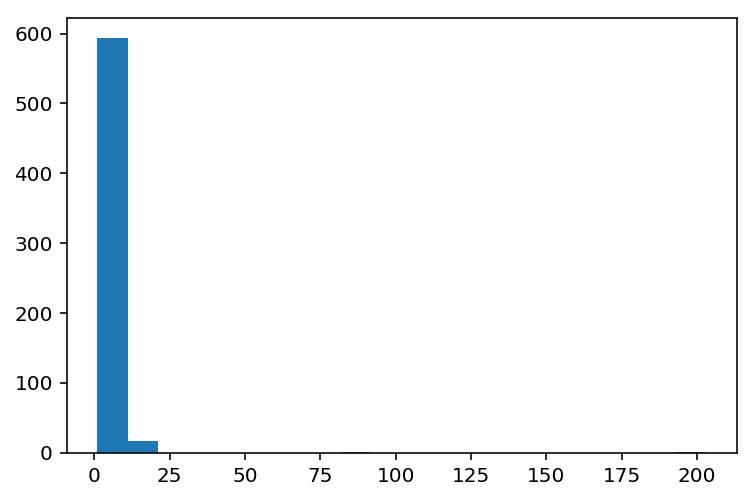

In [144]:
jobs_test_drop['max_years'].hist(grid=False, bins=20)

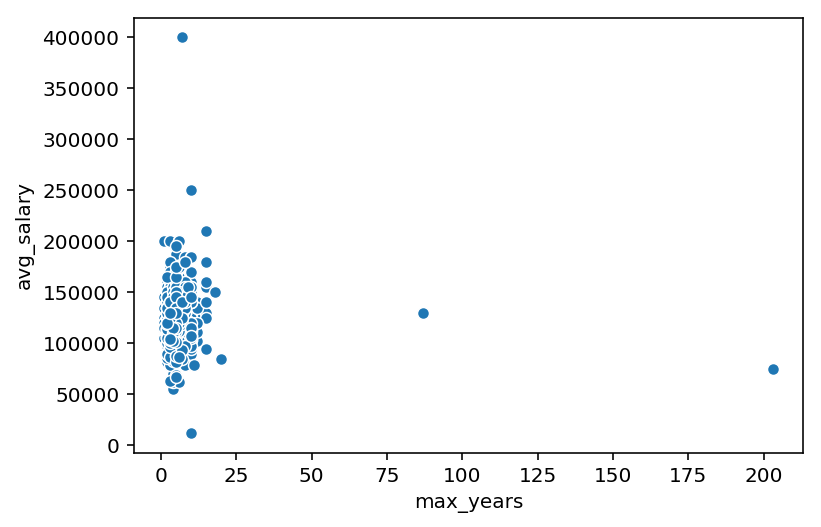

In [145]:
#not looking good... not linear and many weird 'outliers'
sns.scatterplot(y='avg_salary',x='max_years',data=jobs_test_drop)

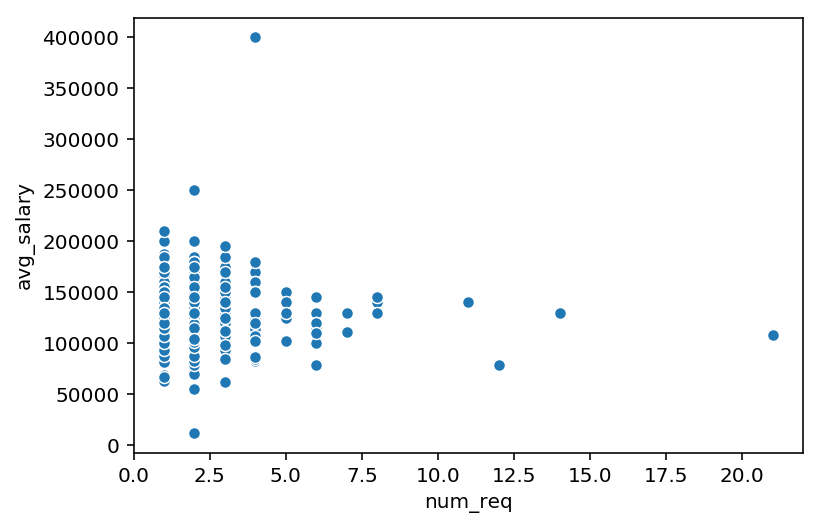

In [146]:
sns.scatterplot(y='avg_salary',x='num_req',data=jobs_test_drop)

In [147]:
test_X = jobs_test_drop.loc[:,['max_years']]
test_y = jobs_test_drop['salary_band']

In [148]:
test_X_train, test_X_test, test_y_train, test_y_test = train_test_split(test_X,test_y,random_state=42, test_size=0.25)

In [149]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(test_X_train, test_y_train)

rfc_pred = rfc.predict(test_X_test)
np.mean(cross_val_score(rfc, test_X_train, test_y_train, cv=3))

0.5272625264885328

In [150]:
#sad
print(classification_report(test_y_test,rfc_pred))

              precision    recall  f1-score   support

        high       0.29      0.11      0.15        38
         low       0.00      0.00      0.00        39
      medium       0.48      0.88      0.62        76

   micro avg       0.46      0.46      0.46       153
   macro avg       0.26      0.33      0.26       153
weighted avg       0.31      0.46      0.35       153



/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Han/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Ensembling


as a recap, 
   - desc works pretty well in general (for all 3 classes)
   - title works well in predicting high and low classes
   - location works well in predicting high and low classes
   - site works well in predicting high and medium classes

In [151]:
X = jobs.loc[:,['company','location','month_posted','desc_nlp','title_nlp','site']]
y = jobs['salary_band']

In [152]:
ensemble = pd.DataFrame(columns=['desc', 'site', 'location', 'title', 'final_pred'])

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25)

In [154]:
cv_desc = CountVectorizer(ngram_range=(1,1))
cv_desc.fit(X_train['desc_nlp'])
len(cv_desc.get_feature_names())    

14240

In [155]:
X_train_desc = pd.DataFrame(cv_desc.transform(X_train['desc_nlp']).todense(), \
                            columns=[x+'_desc' for x in cv_desc.get_feature_names()]) 
X_test_desc = pd.DataFrame(cv_desc.transform(X_test['desc_nlp']).todense(), \
                            columns=[x+'_desc' for x in cv_desc.get_feature_names()]) 

In [156]:
nb_desc = MultinomialNB()
nb_desc.fit(X_train_desc, y_train)
desc_pred = nb_desc.predict(X_test_desc)
# np.mean(cross_val_score(nb, X_train_desc, y_train, cv=3))

In [157]:
# best model so far
print(classification_report(y_test,desc_pred))

              precision    recall  f1-score   support

        high       0.76      0.23      0.36        56
         low       0.63      0.33      0.44        57
      medium       0.62      0.92      0.74       138

   micro avg       0.63      0.63      0.63       251
   macro avg       0.67      0.50      0.51       251
weighted avg       0.66      0.63      0.59       251



In [158]:
ensemble['desc'] = desc_pred

In [159]:
X_cat = labeler.fit_transform(X[['site']]).toarray()
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat,y,random_state=42, test_size=0.25)

rfc_site = RandomForestClassifier(n_estimators=100)
rfc_site.fit(X_cat_train, y_cat_train)

site_pred = rfc_site.predict(X_cat_test)
# np.mean(cross_val_score(rfc, X_cat_train, y_cat_train, cv=3))

In [160]:
ensemble['site'] = site_pred

In [161]:
X['state'] = X['location'].apply(lambda x: x.split(',')[-1])
X_cat = labeler.fit_transform(X[['state']]).toarray()
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat,y,random_state=42, test_size=0.25)

X_cat_train_ = X_cat_train[y_cat_train != 'medium']
y_cat_train_ = y_cat_train[y_cat_train != 'medium']

rfc_loc = RandomForestClassifier(n_estimators=100)
rfc_loc.fit(X_cat_train_, y_cat_train_)

loc_pred = rfc_loc.predict(X_cat_test)
# np.mean(cross_val_score(rfc, X_cat_train, y_cat_train, cv=3))

In [162]:
ensemble['location'] = loc_pred

In [163]:
X_train_title = pd.DataFrame(cv_title.transform(X_train[y_train != 'medium']['title_nlp']).todense(), \
                            columns=[x+'_title' for x in cv_title.get_feature_names()]) 
X_test_title = pd.DataFrame(cv_title.transform(X_test['title_nlp']).todense(), \
                            columns=[x+'_title' for x in cv_title.get_feature_names()]) 

rfc_title = RandomForestClassifier(n_estimators=100)
rfc_title.fit(X_train_title, y_train[y_train != 'medium'])
title_pred = rfc_title.predict(X_test_title)

In [164]:
ensemble['title'] = title_pred

In [165]:
ensemble.head(10)

,desc,site,location,title,final_pred
0,medium,medium,low,high,NaN
1,low,medium,high,low,NaN
2,medium,medium,low,low,NaN
3,medium,medium,low,low,NaN
4,low,medium,high,low,NaN
5,medium,medium,low,low,NaN
6,medium,medium,low,low,NaN
7,medium,medium,high,high,NaN
8,medium,medium,low,low,NaN
9,low,medium,high,low,NaN


In [166]:
# manual voting - logic derived by comparing classification reports (see above recap)
prediction = []
for i in range(len(ensemble)):
    if ensemble.iloc[i,0] == 'medium' and ensemble.iloc[i,1] == 'medium':
        prediction.append('medium')
    elif ensemble.iloc[i,2] == 'high' and ensemble.iloc[i,3] == 'high':
        prediction.append('high')
    elif (ensemble.iloc[20,:4].value_counts()[0] - ensemble.iloc[20,:4].value_counts()[1]) == 0:
        prediction.append(ensemble.iloc[i,0])
    else:
        prediction.append(ensemble.iloc[i,:4].value_counts().index[0])

In [167]:
ensemble['final_pred'] = prediction

In [168]:
#improved!
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

        high       0.85      0.30      0.45        56
         low       0.66      0.33      0.44        57
      medium       0.63      0.92      0.75       138

   micro avg       0.65      0.65      0.65       251
   macro avg       0.71      0.52      0.55       251
weighted avg       0.68      0.65      0.61       251



In [169]:
print(confusion_matrix(y_test,prediction))

[[ 17   2  37]
 [  0  19  38]
 [  3   8 127]]


In [170]:
print(confusion_matrix(y_test,desc_pred))

[[ 13   4  39]
 [  0  19  38]
 [  4   7 127]]


In [171]:
# ensemble model helped improved f1-score of 'high' class
# still cant really differentiate bwt low vs medium 

### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.




In [173]:
# https://www.dropbox.com/s/3ggfy4s6ur9dlb5/alljobs.csv?dl=0
sg_jobs = pd.read_csv('/Users/Han/Downloads/alljobs.csv', index_col=0)

In [174]:
us_jobs = jobs.copy()

In [175]:
sg_jobs.shape, us_jobs.shape

((914, 10), (1002, 10))

In [176]:
us_jobs.head()

,title,company,location,month_posted,desc_clean,avg_salary,site,salary_band,desc_nlp,title_nlp
0,Data Scientist,Michael Page International - US,"Manhattan, NY",10,. . Data Scientist who will be overseeing a te...,175000.0,efc,high,data scientist overseeing team three also will...,data scientist
1,Data Engineer,Glocomms,"New York, NY",9,. . A cybersecurity Start-up is seeking a Data...,135000.0,efc,medium,cybersecurity startup seeking data engineer he...,data engineer
2,Data Engineer,Glocomms,"New York, NY",8,. . A software services and solutions company ...,125000.0,efc,medium,software service solution company recognized g...,data engineer
3,Senior Machine Learning Software Engineer for ...,Jove International,"New York, NY",10,. . This firm have an incredibly strong track ...,400000.0,efc,high,firm incredibly strong track record within sys...,senior machine learning software engineer lead...
4,Big Data Architect,Glocomms,"Santa Clara, CA",8,. . A software services and solutions company ...,145000.0,efc,high,software service solution company recognized g...,big data architect


In [177]:
all_jobs = pd.DataFrame(columns=['title','company','avg_salary','desc','location'])
us_temp = us_jobs.loc[:, ['title_nlp','company', 'avg_salary','desc_nlp','location']]
sg_temp = sg_jobs.loc[:,['job_title', 'company_name','salary_avg', 'job_description','requirements']]

In [178]:
us_temp.columns = ['title','company','avg_salary','desc','location']
us_temp['location'] = 'USA'

In [179]:
sg_temp['desc'] = sg_temp['job_description'] + sg_temp['requirements']
sg_temp['location'] = 'SG'
sg_temp.drop(['job_description','requirements'],axis=1,inplace=True)
sg_temp.reset_index(drop=True, inplace=True)

In [180]:
sg_temp.columns = ['title','company','avg_salary','desc','location']
sg_temp['desc'] = clean_pipeline(sg_temp['desc'])
sg_temp['title'] = clean_pipeline(sg_temp['title'])

In [181]:
sg_temp['company'] = lower_case(sg_temp['company'])
sg_temp['company'] = remove_punc(sg_temp['company'])

us_temp['company'] = lower_case(us_temp['company'])
us_temp['company'] = remove_punc(us_temp['company'])

In [182]:
all_jobs = pd.concat([us_temp, sg_temp]).reset_index(drop=True)

/Users/Han/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


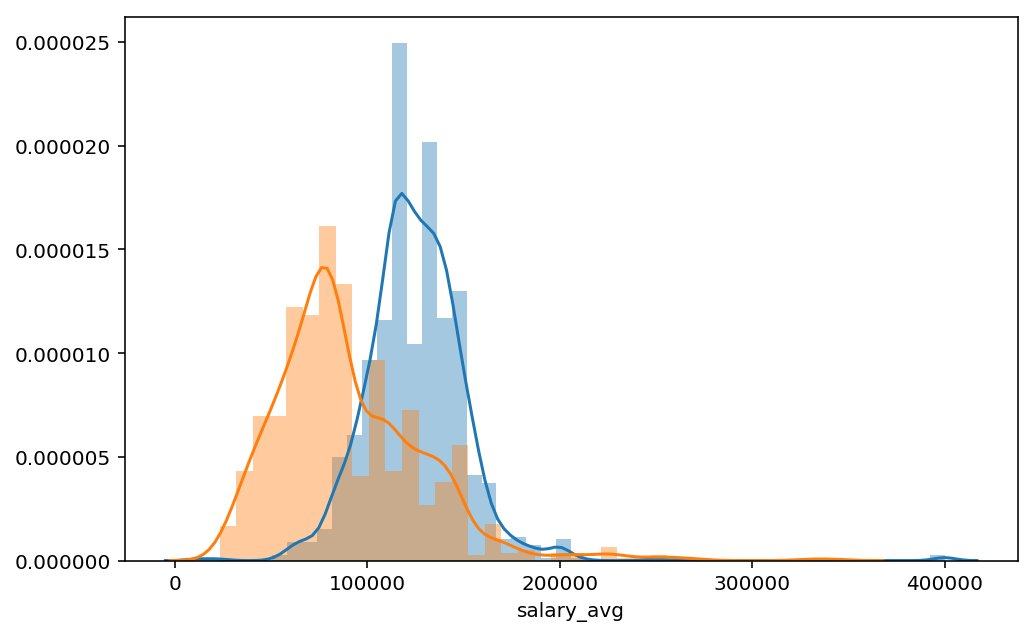

In [183]:
#didnt adjust for fx - assume income tax rate balances out... lol
plt.figure(figsize=(8,5))
sns.distplot(us_jobs['avg_salary'])
sns.distplot((sg_jobs['salary_avg']*12))
plt.show()

In [184]:
X = all_jobs.drop('location', axis=1)
y = all_jobs['location']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.3)

In [185]:
y.value_counts()

USA    1002
SG      914
Name: location, dtype: int64

In [186]:
cv_desc = CountVectorizer(ngram_range=(1,1))
cv_desc.fit(X_train['desc'])
len(cv_desc.get_feature_names())   

17257

In [187]:
X_train_desc = pd.DataFrame(cv_desc.transform(X_train['desc']).todense(), \
                            columns=[x+'_desc' for x in cv_desc.get_feature_names()]) 
X_test_desc = pd.DataFrame(cv_desc.transform(X_test['desc']).todense(), \
                            columns=[x+'_desc' for x in cv_desc.get_feature_names()])

In [188]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_desc, y_train)
desc_pred = rfc.predict(X_test_desc)
np.mean(cross_val_score(rfc, X_train_desc, y_train, cv=3))

0.9321416568854647

In [189]:
print(classification_report(y_test,desc_pred))

              precision    recall  f1-score   support

          SG       0.96      0.92      0.94       268
         USA       0.93      0.97      0.95       307

   micro avg       0.94      0.94      0.94       575
   macro avg       0.95      0.94      0.94       575
weighted avg       0.94      0.94      0.94       575



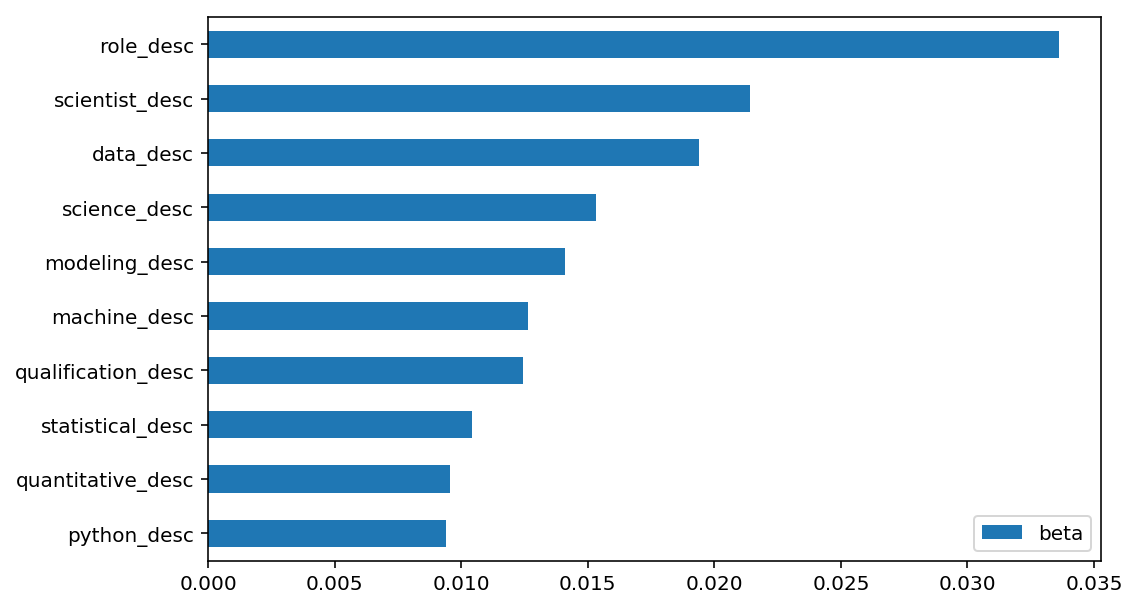

In [190]:
rfc_model = pd.DataFrame(data=rfc.feature_importances_, index=X_train_desc.columns, columns=['beta'])
rfc_model = rfc_model[rfc_model['beta'] != 0].sort_values(by='beta', ascending=False)
rfc_model.head(10).plot.barh(figsize=(8,5))
plt.gca().invert_yaxis()

In [191]:
cv_title = CountVectorizer(ngram_range=(1,1))
cv_title.fit(X_train['title'])
len(cv_title.get_feature_names())   

743

In [192]:
X_train_title = pd.DataFrame(cv_title.transform(X_train['title']).todense(), \
                            columns=[x+'_title' for x in cv_title.get_feature_names()]) 
X_test_title = pd.DataFrame(cv_title.transform(X_test['title']).todense(), \
                            columns=[x+'_title' for x in cv_title.get_feature_names()])

In [193]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_title, y_train)
desc_pred = rfc.predict(X_test_title)
np.mean(cross_val_score(rfc, X_train_title, y_train, cv=3))

0.9410952112835181

In [194]:
print(classification_report(y_test,desc_pred))

              precision    recall  f1-score   support

          SG       0.95      0.94      0.95       268
         USA       0.95      0.96      0.95       307

   micro avg       0.95      0.95      0.95       575
   macro avg       0.95      0.95      0.95       575
weighted avg       0.95      0.95      0.95       575



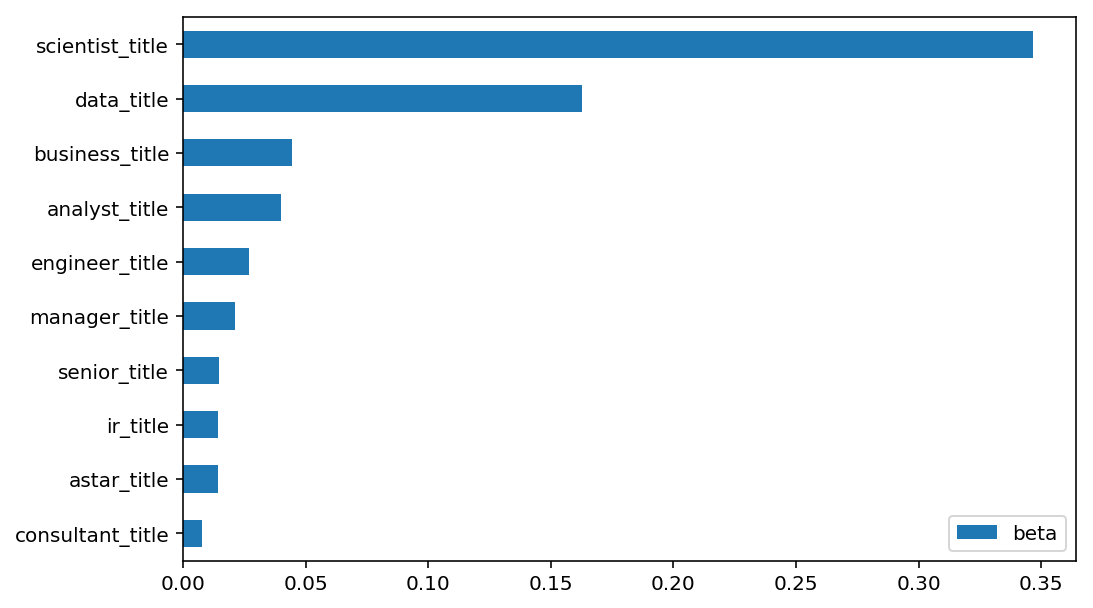

In [195]:
rfc_model = pd.DataFrame(data=rfc.feature_importances_, index=X_train_title.columns, columns=['beta'])
rfc_model = rfc_model[rfc_model['beta'] != 0].sort_values(by='beta', ascending=False)
rfc_model.head(10).plot.barh(figsize=(8,5))
plt.gca().invert_yaxis()

In [200]:
cv_coy = CountVectorizer(ngram_range=(1,1))
cv_coy.fit(X_train['company'])
len(cv_coy.get_feature_names())  

1059

In [204]:
X_train_coy = pd.DataFrame(cv_coy.transform(X_train['company']).todense(), \
                            columns=[x+'_coy' for x in cv_coy.get_feature_names()]) 
X_test_coy = pd.DataFrame(cv_coy.transform(X_test['title']).todense(), \
                            columns=[x+'_coy' for x in cv_coy.get_feature_names()])

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_coy, y_train)
coy_pred = rfc.predict(X_test_coy)
np.mean(cross_val_score(rfc, X_train_coy, y_train, cv=3))

0.9955223756043684

In [205]:
print(classification_report(y_test,coy_pred))

              precision    recall  f1-score   support

          SG       1.00      0.04      0.08       268
         USA       0.54      1.00      0.70       307

   micro avg       0.55      0.55      0.55       575
   macro avg       0.77      0.52      0.39       575
weighted avg       0.76      0.55      0.41       575



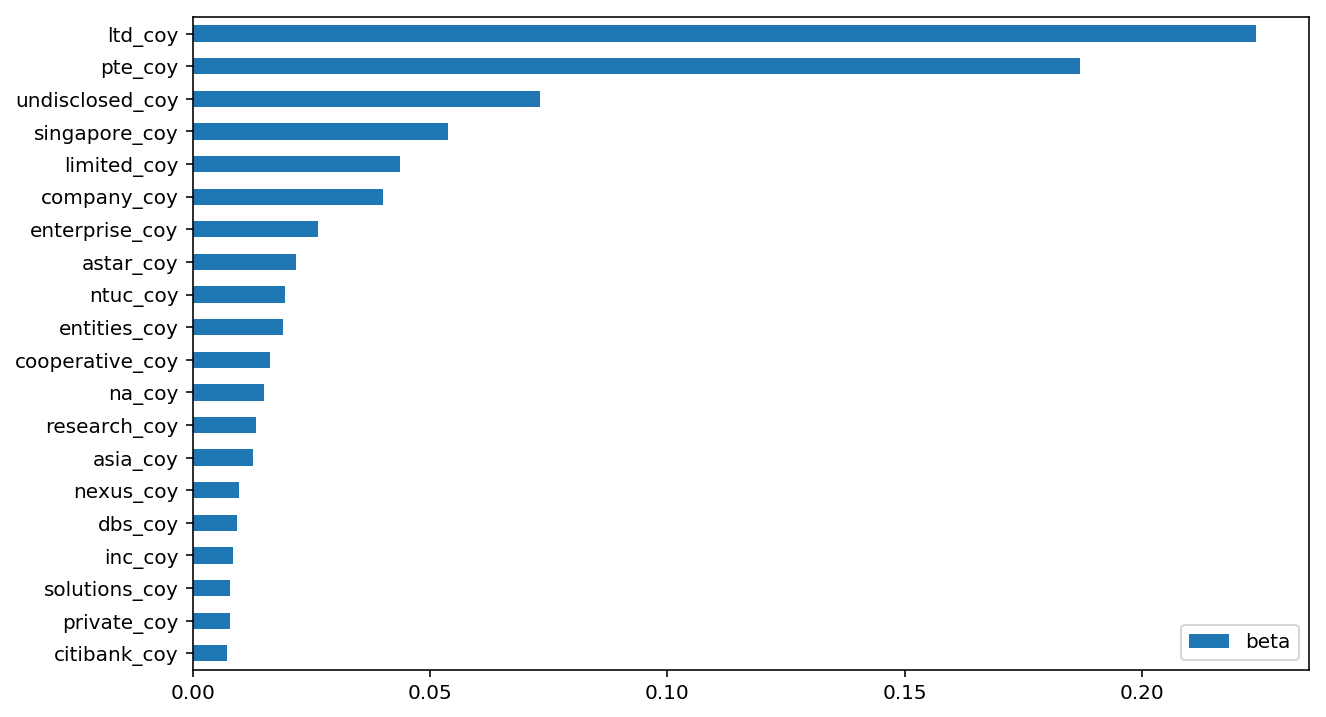

In [206]:
rfc_model = pd.DataFrame(data=rfc.feature_importances_, index=X_train_coy.columns, columns=['beta'])
rfc_model = rfc_model[rfc_model['beta'] != 0].sort_values(by='beta', ascending=False)
rfc_model.head(20).plot.barh(figsize=(10,6))
plt.gca().invert_yaxis()

### Combining all

In [211]:
X_train_nlp = X_train_desc.join(X_train_title)
X_test_nlp = X_test_desc.join(X_test_title)

In [212]:
X_train_all = X_train_nlp.join(X_train_coy)
X_train_all['avg_salary'] = X_train['avg_salary'].reset_index(drop=True)

In [214]:
X_test_all = X_test_nlp.join(X_test_coy)
X_test_all['avg_salary'] = X_test['avg_salary'].reset_index(drop=True)

In [215]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_all, y_train)
rfc_pred = rfc.predict(X_test_all)
np.mean(cross_val_score(rfc, X_train_all, y_train, cv=3))

0.9761338073215463

In [216]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

          SG       1.00      0.93      0.97       268
         USA       0.94      1.00      0.97       307

   micro avg       0.97      0.97      0.97       575
   macro avg       0.97      0.97      0.97       575
weighted avg       0.97      0.97      0.97       575



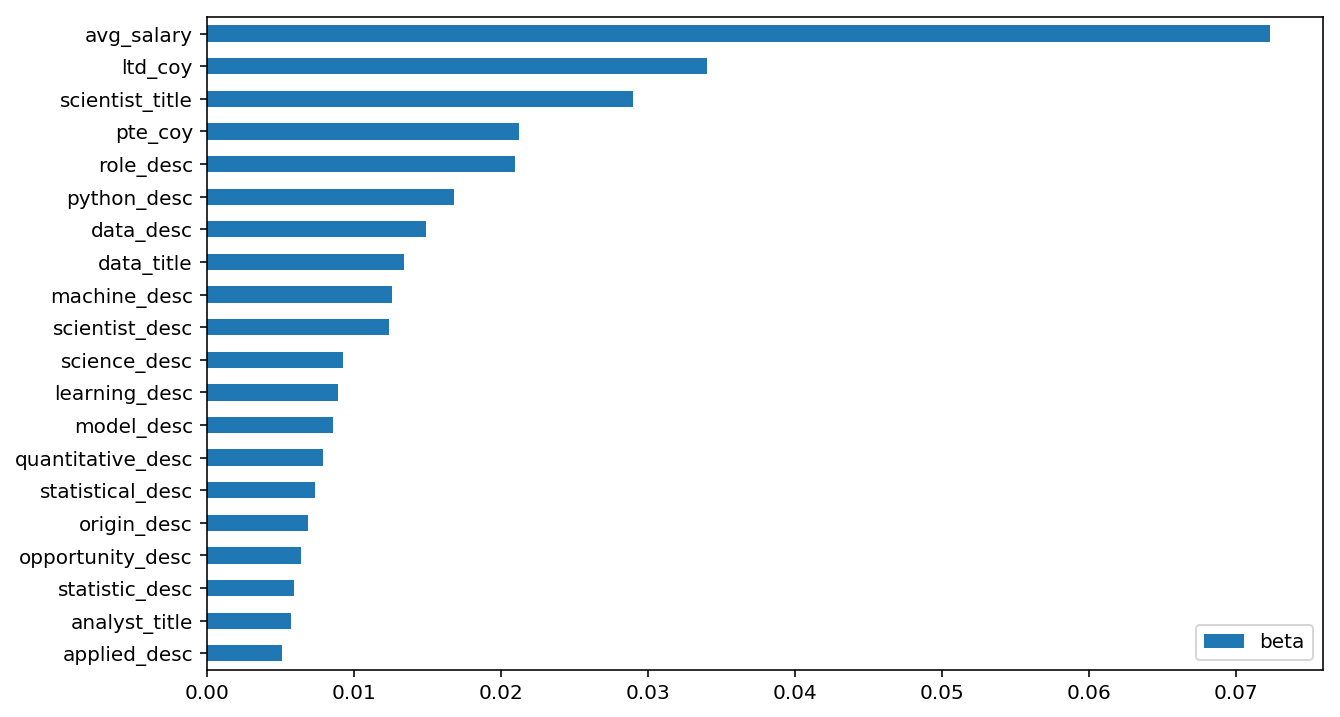

In [218]:
rfc_model = pd.DataFrame(data=rfc.feature_importances_, index=X_train_all.columns, columns=['beta'])
rfc_model = rfc_model[rfc_model['beta'] != 0].sort_values(by='beta', ascending=False)
rfc_model.head(20).plot.barh(figsize=(10,6))
plt.gca().invert_yaxis()

### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.




In [334]:
# switch to binary class
salary_band = []
for job in jobs['avg_salary']:
    if job > jobs['avg_salary'].mean():
        salary_band.append('high')
    else:
        salary_band.append('low')

In [ ]:
cv_desc = CountVectorizer(ngram_range=(1,1))
cv_desc.fit(jobs['desc_nlp'])  
X_desc = pd.DataFrame(cv_desc.transform(jobs['desc_nlp']).todense(), \
                            columns=[x+'_desc' for x in cv_desc.get_feature_names()])

In [ ]:
cv_title = TfidfVectorizer(ngram_range=(1,1), max_df=150)
cv_title.fit(jobs['title_nlp'])
X_title = pd.DataFrame(cv_title.transform(jobs['title_nlp']).todense(), \
                            columns=[x+'_title' for x in cv_title.get_feature_names()]) 

In [291]:
jobs['state'] = jobs['location'].apply(lambda x: x.split(',')[-1])
jobs['state'] = jobs['state'].apply(lambda x : 'Others' if x in minority_states else x)
X_cat = pd.DataFrame(labeler.fit_transform(jobs[['site','state']]).toarray(), columns = labeler.categories_[0].tolist() + labeler.categories_[1].tolist())


In [335]:
X = pd.concat([X_desc, X_title, X_cat], axis=1)
y = salary_band
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25)

In [362]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
np.mean(cross_val_score(nb, X_train, y_train, cv=3))

0.6871363275145735

In [363]:
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

        high       0.71      0.63      0.67       124
         low       0.67      0.75      0.71       127

   micro avg       0.69      0.69      0.69       251
   macro avg       0.69      0.69      0.69       251
weighted avg       0.69      0.69      0.69       251



In [359]:
nb_proba = nb.predict_proba(X_test)
threshold = pd.DataFrame(nb_proba, columns=nb.classes_).join(pd.DataFrame(nb_pred, columns =['old_pred']))

In [378]:
threshold['new_pred'] = threshold['high'].apply(lambda x: 'high' if x >= 0.75 else 'low')

In [379]:
threshold[threshold['old_pred'] != threshold['new_pred']]

,high,low,old_pred,new_pred
16,0.721918,0.278082,high,low
72,0.708118,0.291882,high,low


In [398]:
y_test_binary = [1 if x == 'high' else 0 for x in y_test]

In [399]:
fpr, tpr, _ = roc_curve(y_test_binary, nb_proba[:,0])
roc_auc = auc(fpr, tpr)

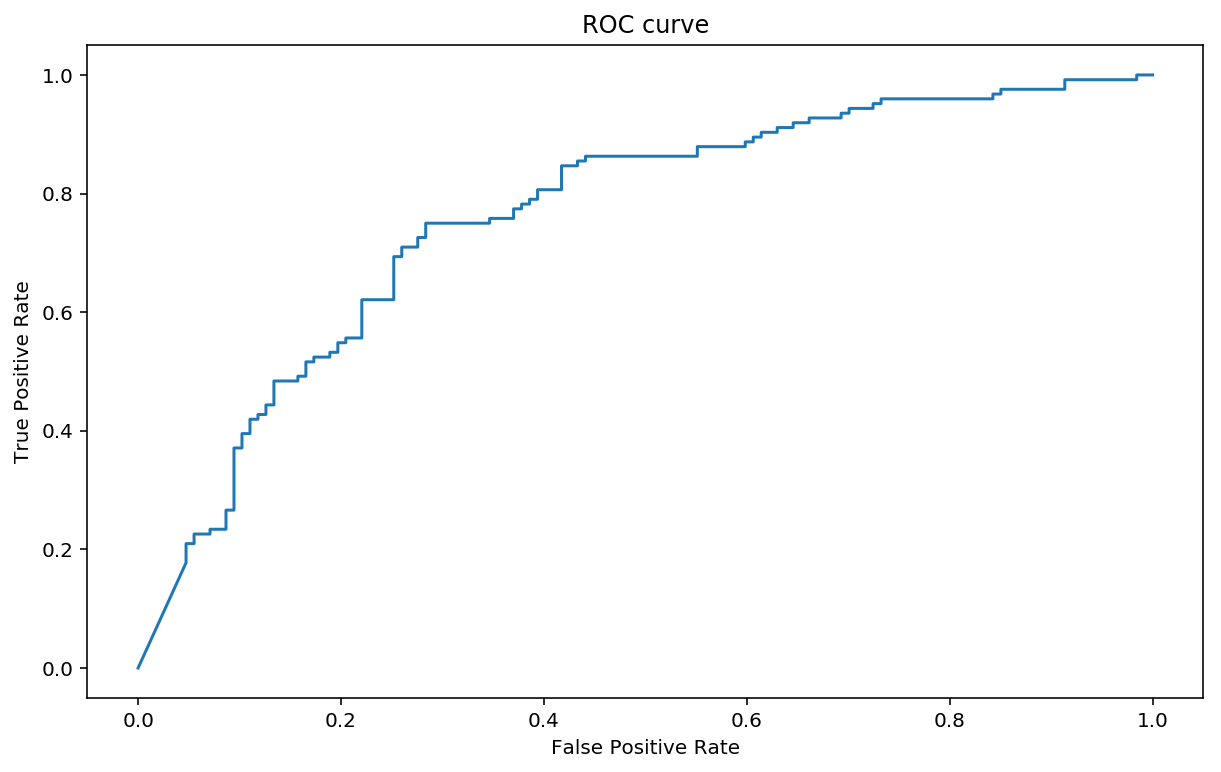

In [407]:
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')

plt.show()